LSTM 기반의 삼성전자 주가 예측 예제
 - yahoo finance 에서 데이터 다운로드 후 3일(3MA), 5일(5MA) 가격이평선 추가

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [2]:
raw_df = pd.read_csv('data/005930.KS.csv')  # yahoo finance 로부터 데이터 다운로드
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3M,5M
0,2000-01-04,6000,6110,5660,6110,4651.739746,74195000,NaN,NaN
1,2000-01-05,5800,6060,5520,5580,4248.231445,74680000,NaN,NaN
2,2000-01-06,5750,5780,5580,5620,4278.685547,54390000,4392.885579,NaN
3,2000-01-07,5560,5670,5360,5540,4217.779785,40305000,4248.232259,NaN
4,2000-01-10,5600,5770,5580,5770,4392.885742,46880000,4296.450358,4357.864453


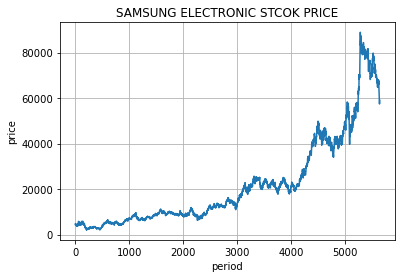

In [3]:
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['Adj Close'], label='Adj Close')
plt.show()

데이터 전처리 (Missing Data 처리, 정규화 등)

In [4]:
# 통계정보 확인
raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3M,5M
count,5645.000000,5645.000000,5645.000000,5645.000000,5645.000000,5.645000e+03,5643.000000,5641.000000
mean,25046.563330,25298.256864,24788.434012,25040.914083,21904.088022,2.175597e+07,21900.607179,21897.257848
std,20220.023828,20385.326290,20045.348191,20204.027767,19880.184969,1.542621e+07,19873.698156,19867.796875
min,2540.000000,2760.000000,2420.000000,2730.000000,2078.436279,0.000000e+00,2124.115804,2139.342773
25%,10200.000000,10340.000000,10040.000000,10200.000000,7852.012695,1.180825e+07,7823.954508,7832.582617
50%,16700.000000,16920.000000,16500.000000,16700.000000,13410.837890,1.774472e+07,13365.140300,13392.578320
75%,31700.000000,32260.000000,31440.000000,31840.000000,27068.371090,2.720500e+07,27122.211265,27064.969920
max,90300.000000,96800.000000,89500.000000,91000.000000,88908.171880,1.642150e+08,88354.533850,87892.081250


In [5]:
# Missing Data 확인
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3M           2
5M           4
dtype: int64

In [6]:
# 최소값이 0 인 column 체크

for col in raw_df.columns:

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Volume <class 'str'>


In [7]:
raw_df.loc[raw_df['Volume']==0]

,Date,Open,High,Low,Close,Adj Close,Volume,3M,5M
23,2000-02-04,5130,5130,5130,5130,3905.632568,0,3936.086344,4021.355322
41,2000-03-01,5120,5120,5120,5120,3898.019287,0,3816.811035,3841.681396
66,2000-04-05,6800,6800,6800,6800,5177.057617,0,5253.190918,5245.577051
72,2000-04-13,6910,6910,6910,6910,5260.804199,0,5309.021973,5393.275586
84,2000-05-01,6000,6000,6000,6000,4567.991699,0,4415.725423,4360.909277
...,...,...,...,...,...,...,...,...,...
5564,2022-02-28,71900,71900,71900,71900,71530.257810,0,71397.609380,72405.731250
5567,2022-03-04,72900,72900,72900,72900,72525.117190,0,72127.174480,71888.407810
5570,2022-03-10,69500,69500,69500,69500,69142.601560,0,69341.572920,70614.990630
5573,2022-03-15,70200,70200,70200,70200,69839.000000,0,69772.677080,69520.646880


In [8]:
# 각 column에 0 몇개인지 확인

for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 127
3M: 0
5M: 0


In [9]:
# 먼저 0 을 NaN 으로 바꾼후, Missing Data 처리
raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 몇개인지 확인
for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3M: 0
5M: 0


In [10]:
# missing data 확인
raw_df.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume       127
3M             2
5M             4
dtype: int64

In [11]:
raw_df.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume        True
3M            True
5M            True
dtype: bool

In [12]:
raw_df.loc[raw_df['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3M,5M


In [13]:
# missing data 처리

raw_df = raw_df.dropna()
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3M           0
5M           0
dtype: int64

In [14]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', '3M', '5M', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

          Open      High       Low     Close  Adj Close        3M        5M  \
0     0.034868  0.032008  0.036288  0.034440   0.026655  0.025192  0.025698   
1     0.037375  0.035517  0.038470  0.034440   0.026655  0.025634  0.025094   
2     0.034982  0.031689  0.036518  0.033873   0.026217  0.026163  0.025343   
3     0.034868  0.031689  0.036059  0.033760   0.026129  0.025987  0.025503   
4     0.036235  0.033177  0.037437  0.035120   0.027181  0.026163  0.026018   
...        ...       ...       ...       ...        ...       ...       ...   
5509  0.643345  0.599107  0.633670  0.621615   0.639430  0.651076  0.664183   
5510  0.628532  0.587410  0.624483  0.619350   0.637127  0.646051  0.656019   
5511  0.630811  0.599107  0.634819  0.630679   0.648644  0.645664  0.652753   
5512  0.643345  0.607614  0.641709  0.635210   0.653250  0.650303  0.652986   
5513  0.645624  0.603360  0.649747  0.637476   0.655554  0.656488  0.654153   

        Volume  
0     0.285359  
1     0.363715  


주가예측을 위해 3MA, 5MA, Adj Close 항목을 feature 선정
 - 정답은 Adj Close 선정
 - 시계열 데이터를 위한 window_size = 40 선정

In [15]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [16]:
# feature_df, label_df 생성

feature_cols = [ '3M', '5M', 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [17]:
feature_df.head()

,3M,5M,Adj Close
0,0.025192,0.025698,0.026655
1,0.025634,0.025094,0.026655
2,0.026163,0.025343,0.026217
3,0.025987,0.025503,0.026129
4,0.026163,0.026018,0.027181


In [18]:
label_df.head()

,Adj Close
0,0.026655
1,0.026655
2,0.026217
3,0.026129
4,0.027181


In [19]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(5514, 3) (5514, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [20]:
window_size = 40

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5474, 40, 3) (5474, 1)


학습데이터, 테스트데이터 생성

In [21]:
# train, test 분리

split = int(len(X)*0.95)
#split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5200, 40, 3) (5200, 1)
(274, 40, 3) (274, 1)


모델 구축 및 컴파일

In [22]:
# model 생성

model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

In [23]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=300, batch_size=16,
          callbacks=[early_stop])

Epoch 1/300
325/325 [==============================] - 4s 8ms/step - loss: 7.0130e-04 - mae: 0.0100 - val_loss: 4.6396e-04 - val_mae: 0.0170
Epoch 2/300
325/325 [==============================] - 2s 7ms/step - loss: 1.1851e-04 - mae: 0.0068 - val_loss: 3.5987e-04 - val_mae: 0.0139
Epoch 3/300
325/325 [==============================] - 2s 7ms/step - loss: 1.1605e-04 - mae: 0.0067 - val_loss: 3.1517e-04 - val_mae: 0.0131
Epoch 4/300
325/325 [==============================] - 2s 7ms/step - loss: 8.5345e-05 - mae: 0.0058 - val_loss: 2.8091e-04 - val_mae: 0.0126
Epoch 5/300
325/325 [==============================] - 2s 7ms/step - loss: 8.2725e-05 - mae: 0.0059 - val_loss: 2.9867e-04 - val_mae: 0.0138
Epoch 6/300
325/325 [==============================] - 2s 7ms/step - loss: 8.4263e-05 - mae: 0.0060 - val_loss: 2.9687e-04 - val_mae: 0.0137
Epoch 7/300
325/325 [==============================] - 2s 7ms/step - loss: 6.7900e-05 - mae: 0.0053 - val_loss: 3.4523e-04 - val_mae: 0.0152
Epoch 8/300
3

In [25]:
pred = model.predict(x_test)
print(pred[0], y_test[0])

9/9 [==============================] - 0s 4ms/step
[0.9077611] [0.89944104]


예측을 통한 정답과의 비교 
(오차계산 MAPE 사용, 평균절대값백분율오차)

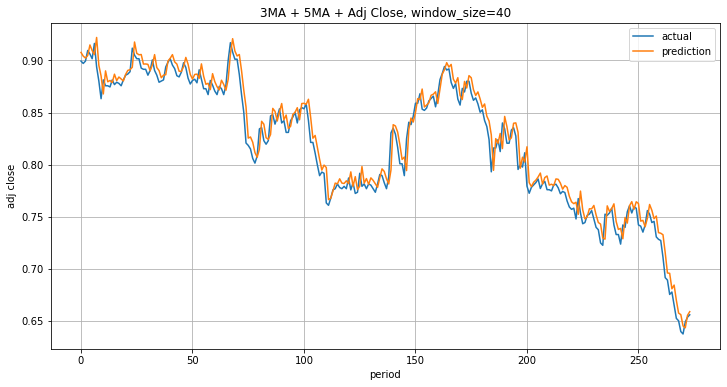

In [26]:

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [27]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.011603255880753243
